In [2]:
import os
import time
import pickle
import copy
import numpy as np
from importlib import reload
import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from common import misc
from common.baseclasses import AWA
from common import plotting
from common import numerical_recipes as numrec
from matplotlib import pyplot as plt

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


# Load probe and encoding from file

In [3]:
probe_name = 'hyperboloid'
#P = PCE.load(probe_name,PCE.Probe)
#Enc = P.gapSpectroscopy(recompute=False,reload=True).Encode(reload=True)
Probe = PCE.load(probe_name,PS.EncodedEigenfields)

<__init__._ProbesCollection.__setitem__>:
	Registering probe "hyperboloid"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_EncodedEigenfields.pickle"!


In [4]:
#The stored `Encoding` object should already have this library computed.
#Enc.build_Rmat2D_library(qps=np.logspace(-3, 2, 50))

# Define fast calculator for 2D material on substrate

This tool is optimized to quickly simulate near-field signal at light frequency $\omega$ from a 2D material of conductivity $\sigma(\omega)$ sitting atop a substrate material with permittivity $\epsilon(\omega)$.  In practice, throughout this business the optical conductivity $\sigma$ is re-parametrized into a more convenient measure called the "plasmon wavevector" $q_p$ which is defined as:

$q_p(\omega)=i\omega/(2\pi\sigma(\omega))$

In terms of this wavevector value, the near-field reflectivity of the 2D material atop the substrate is given as function of illumination wave-vector $q$ by:

$R(q,\omega) = (\beta \cdot q_{p,scr} - q)/(q_{p,scr}-q)$.

Here $\beta(\omega)\equiv (\epsilon(\omega)-1)/(\epsilon(\omega)+1)$ describes the reflectivity of the substrate even if no 2D material were present (in which case $q_p\rightarrow\infty$), and $q_{p,scr}$ is the screened plasmon wavevector given by $q_{p,scr}(\omega)=q_p(\omega) \cdot (\epsilon(\omega)+1)/2$.

In truth, with an optical probe of typical tip radius $a$, the strength of optical interaction between the probe and the 2D material will be controlled by the dimensionless product $q_p \cdot a$.  This can be seen by the fact that such a probe may illuminate the 2D material with light fields of characteristic momentum $q^*\sim 1/a$.

Thus, calculations are all performed by providing the dimensionless value of $q_p\cdot a$ in lieu of the dimensionful plasmon wavevector, and also any extraction of $q_p$ with this tool will also measure the plasmon wavevector in units of $q^*$.

In [8]:
# These are a bunch of tools to accelerate using the library to solve the inverse problem.
from scipy.optimize import leastsq

# This class will take a Probe (and some Probe parameters) and return a calculator for the signal
class S_vs_qp_predictor(object):

    def __init__(self, Probe,
                 zmin=.1, A=2, Nts=24,
                 harmonic=2,
                Sref=1):

        # Demodulation quadrature nodes (and weights) in time
        self.ts,self.dts=numrec.GetQuadrature(N=Nts,xmin=-.5,xmax=0,
                                              quadrature=numrec.GL)
        self.kernel = np.cos(2*np.pi*harmonic*self.ts) * self.dts
        self.kernel -= np.mean(self.kernel)

        # Corresponding gap heights
        self.at_gaps = zmin + A*(1+np.cos(2*np.pi*self.ts))
        self.freq = Probe.get_probe().get_freq()
        self.Probe = Probe
        self.Sref = Sref # Signal value to which we pretend data were referenced

    def massage_arg(self,arg): #Assume argument must have positive imaginary

        return arg.real + 1j*np.abs(arg.imag)

    def __call__(self, qp, eps): #This simulates a 2D material 

        #Inhibit negative imaginary for qp or eps
        qp = self.massage_arg(qp)
        eps = self.massage_arg(eps)

        # "Lookup" eigenfield scattering matrix
        R0 = self.Probe.interpolate_Rmat2D_from_library(qp, eps)

        # Compute scattered field at gap heights; output raw array
        erad_vs_gap = self.Probe.EradVsGap(self.at_gaps, freq=self.freq,
                                         RMat0=R0, as_AWA = False )

        # here is the demodulation! at quadrature nodes
        erad_vs_gap = np.array(erad_vs_gap)
        Sn = 4 * np.sum( self.kernel * erad_vs_gap, axis=0)

        return complex(Sn/self.Sref)
        
def residual(args,S_target_r,S_target_i,
             S_predictor,eps,exp=1):

    S_target = S_target_r+1j*S_target_i
    qpr,qpi = args
    qp = qpr+1j*qpi

    diff = S_target - S_predictor(qp,eps)
    diffr = float(diff.real)
    diffi = float(diff.imag)

    # Minimize absolute value of imaginary and real differences separately
    return np.abs(np.array((diffr,diffi)))**exp

# Practice computing some spectra for different $q_p$

In [13]:
# Build our calculator.
# Tapping parameters (in units of tip radius `a`):
#    zmin is the distance of closest approach
#    tapping amplitude A is the amplitude of the tapping sine wave
#    If we take `a=20 nm`, values chosen here correspond with 
#    closest approach of 2 nm and tapping amplitude of 80 nm.
# Other parameters:
#    This will compute the second harmonic signal normalized to `Sref`.
#    If we had previously computed e.g. signal from gold, call it `S_Au`,
#    then we could supply that for `Sref`.
Calculator = S_vs_qp_predictor(Probe,
                                 zmin=.1, A=4, Nts=24,
                                 harmonic=2,
                                Sref=1)

Sn_Au = Calculator(qp = 1e5, eps = -1e5)
Calculator.Sref = Sn_Au

In [24]:
# Using the library, we can rapidly compute near-field contrast of 2D material on any substrate.
# Choose silicon oxide permittivity as our substrate.
from NearFieldOptics import Materials as M
freqs = np.linspace(600,1500,100)
epss = M.SiO2_300nm.epsilon(freqs)

# Decide at what tip-sample gaps we will compute scattered field.  This scattered field E vs. gap = "approach curve."
zmin=.1; A=5 # minimum approach height, and tapping amplitude (= 5 x tip radius ~ 100 nm)
at_gaps = np.linspace(zmin,zmin+2*A,100)

# Choose many hypothetical values of plasma momentum `qp` of 2D layer.  Compute scattered field at all gaps.
Sns={}
for qp in np.logspace(-3,1,5):

    #For this value of `qp`, compute a series of optical contrasts
    Sns_at_qp = []
    for i,eps in enumerate(epss):
        p = i/len(epss)*100
        print('qp = %s, Progress=%i%%'%(qp,p),end='\r',flush=True)
        Sn = Calculator(qp,eps)
        Sns_at_qp.append(Sn)
    print('\n')

    Sns_at_qp = AWA(Sns_at_qp,axes=[freqs],axis_names=['$\omega$ (cm$^{-1}$)'])
    Sns[qp] = Sns_at_qp


qp = 0.001, Progress=99%

qp = 0.01, Progress=99%

qp = 0.1, Progress=99%

qp = 1.0, Progress=99%

qp = 10.0, Progress=99%



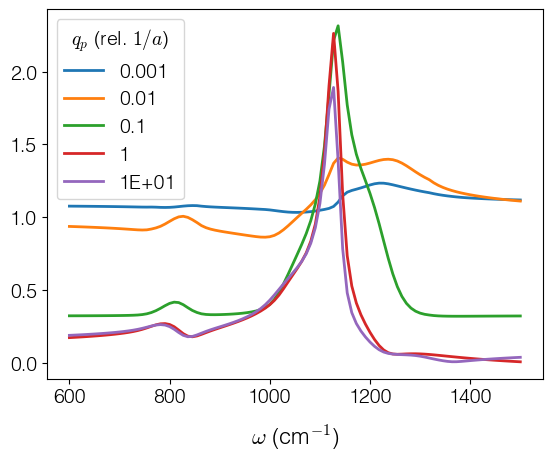

In [19]:
# Plot the spectrum for each choice of `qp`.
# Decreasing `qp` means the 2D material gets more metallic.
harmonic = 2
qps = sorted(list(Sns.keys()))
for qp in qps:
    np.abs(Sns[qp]).plot(label='%1.1G'%qp)
plt.legend(title='$q_p$ (rel. $1/a$)')

# Inversion of $q_p$

## Practice inversion at one permittivity

In [25]:
# Parameters for probe model
harmonic = 2
zmin = 0.1 # distance of closest approach of probe to sample ( units of tip radius)
A=4 # tapping amplitude (units of tip radius)

# Something we knew about our measurement - the substrate permittivity
eps = 2
# The ground truth
qp_actual = .5+.1j

# The simulated signal
S_target = Calculator(qp_actual,eps) # suppose this is were our measurement

# Least squares solution for inversion
t0 = time.time()
exp=1
qp_0 = (.1,.1) # starting guess for `qp`
result = leastsq(residual,qp_0, args=(S_target.real,S_target.imag,
                                    Calculator,eps,exp),
                 factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]

print('Elapsed:',time.time()-t0)
qp_predicted = result[0]+1j*result[1]

print('qp Actual:',qp_actual)
print('qp Predicted:',qp_predicted)

print('S actual:',Calculator(qp_actual,eps))
print('S predicted:',Calculator(qp_predicted,eps))



Elapsed: 0.22501397132873535
qp Actual: (0.5+0.1j)
qp Predicted: (0.49999999999845424+0.09999999999912265j)
S actual: (0.0332517712445306+0.013638035435670801j)
S predicted: (0.033251771244347104+0.013638035435927995j)


## Inversion at a series of known permittivities $\varepsilon(\omega)$, to obtain spectrum $q_p(\omega)$

We will pretend we have acquired some near-field data from a "unknown" 2D material upon a "known" substrate - this means, $q_p(\omega)$ is not known, but we suppose that $\epsilon(\omega)$ is known because we have pre-characterized the substrate.  This means to say, suppose we have acquired a gold-normalized spectrum from our substrate, and that our model (`Calculator`, with `Sref` set to `S_Au`) successfully reproduces the substrate spectrum.

Now we are ready to supply our gold-normalized spectrum from the 2D material.  By supplying known values of $\epsilon(\omega)$, we can fit our near-field signal at each frequency to the $q_p(\omega)$ of best match.

Text(0, 0.5, '$S_2$ (rel. Au)')

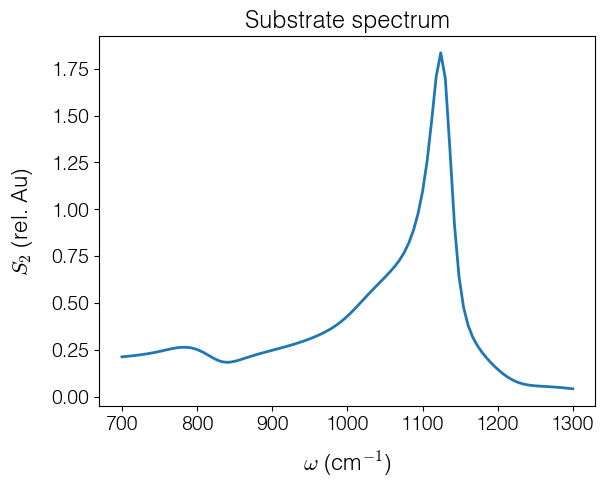

In [30]:
#--- Decide the underlying substrate material we will simulate
# Here we will choose SiO2, which is assumed to be thick enough to resemble bulk SiO2
freqs = np.linspace(700,1300,100)
epss = M.SiO2_300nm.epsilon(freqs) # Our `known` permittivities of substrate at our energies of measurement

S0 = [Calculator(qp=1e3,eps=eps) \
      for eps in epss] # Predict spectrum of underlying substrate
S0 = AWA(S0,axes=[freqs],axis_names=['$\omega$ (cm$^{-1}$)'])

np.abs(S0).plot()
plt.title('Substrate spectrum')
plt.ylabel('$S_2$ (rel. Au)')


In [31]:
#--- Build ground truth qp values, and simulate the measurement
# Either we will do fitting to $q_p$ from a simulated target
# (a synthesized example of data we might measure with noise on top)
# OR we will be fitting to actual gold-normalized data

simulate_target = True
if simulate_target:
    Q=5 # plasmonic quality factor
    qps_actual = np.linspace(.05,0.1,len(freqs))*(1+1j/Q)
    S_targets = [Calculator(qp_actual,eps) 
                 for qp_actual,eps in zip(qps_actual,epss)]
    S_targets = np.array(S_targets) # Model will try to reproduce this 'target'
    
    #--- Add noise to the simulated values (obviously remove this for actual data)
    n=0.05
    S_targets += n*np.random.randn(len(freqs))
    
else:
    # Here put our measurement: numeric complex values of the measured normalized signal
    pass

#--- Try to predict a signal matching target at each frequency

exp=1 # This is a parameter of the residual function for fitting
qps_pred = [] # We will fill this with predicted `q_p` values at each frequency
qp_pred = 0.1+.1j # This is an initial guess to get the nonlinear fitting started

for freq,eps,S_target in zip(freqs,epss,S_targets):
    t0 = time.time()
    x0 = (qp_pred.real,qp_pred.imag)
    result = leastsq(residual,x0, args=(S_target.real,S_target.imag,
                                        Calculator,eps,exp),
                     factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]
    print('freq=%1.2f'%freq,'; Elapsed: %1.3f'%(time.time()-t0),
          end='\r',flush=True)
    qp_pred = result[0]+1j*result[1]
    qps_pred.append(qp_pred)


#--- See what spectrum is implied by the predicted qp values

# coerce to what predictor "sees" during optimization
qps_pred = Calculator.massage_arg(np.array(qps_pred))
S_preds = [Calculator(qp_pred,eps) for qp_pred,eps in zip(qps_pred,epss)]

Text(0, 0.5, '$q_p \\cdot a$')

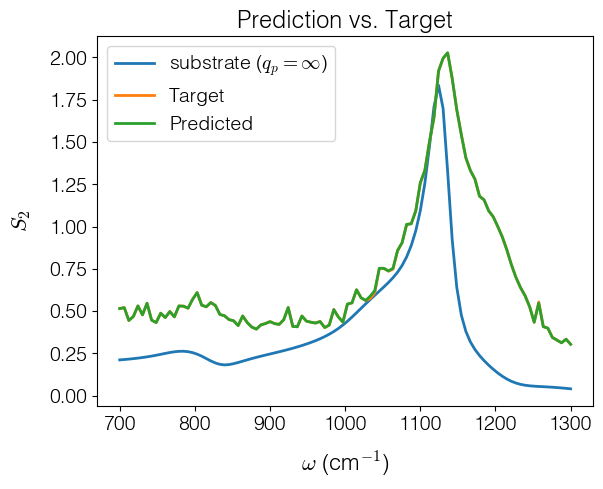

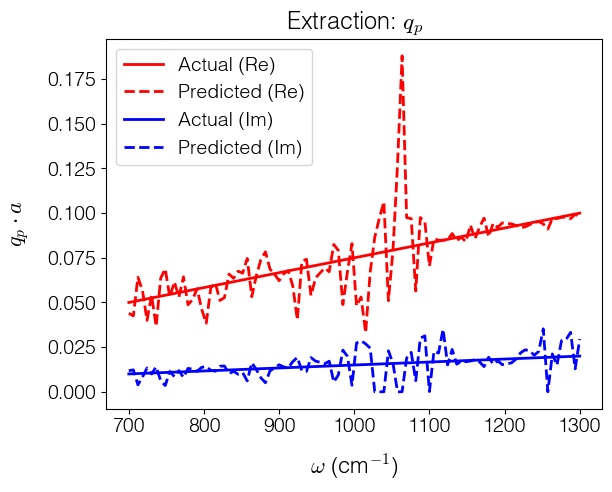

In [33]:
# Let's see how well the "best fit" matches the target!

#--- Plot signals
plt.figure()
plt.plot(freqs,np.abs(S0),label='substrate ($q_p = \infty$)')
plt.plot(freqs,np.abs(S_targets),label='Target')
plt.plot(freqs,np.abs(S_preds),label='Predicted')
plt.legend()
plt.title('Prediction vs. Target')
plt.xlabel(r'$\omega$ (cm$^{-1}$)')
plt.ylabel(r'$S_%i$'%harmonic)

# Let's also see how the extracted $q_p$ depends on frequency,
# and how well it matches the `ground truth` values (which had no noise)

#--- Plot predicted qp vs. ground truth
plt.figure()
plt.plot(freqs,qps_actual.real,label='Actual (Re)',color='r')
plt.plot(freqs,qps_pred.real,label='Predicted (Re)',color='r',ls='--')
plt.plot(freqs,qps_actual.imag,label='Actual (Im)',color='b')
plt.plot(freqs,qps_pred.imag,label='Predicted (Im)',color='b',ls='--')
plt.legend()
plt.title(r'Extraction: $q_p$')
plt.xlabel(r'$\omega$ (cm$^{-1}$)')
plt.ylabel(r'$q_p \cdot a$')